# Epileptic seizure recognition

Let's start by importing the necessary libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectKBest, RFECV
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
#from xgboost.sklearn import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sn
#import keras
#from keras.models import Sequential
#from keras.layers import Dense, BatchNormalization, Dropout
#from keras import regularizers

import warnings; warnings.simplefilter('ignore')
%matplotlib inline

## Dataset

- The original dataset from the reference consists of 5 different folders, each with 100 files, with each file representing a single subject/person. Each file is a recording of brain activity for 23.6 seconds. 

- The corresponding time-series is sampled into 4097 data points. Each data point is the value of the EEG recording at a different point in time. So we have total 500 individuals with each has 4097 data points for 23.5 seconds.

- We divided and shuffled every 4097 data points into 23 chunks, each chunk contains 178 data points for 1 second, and each data point is the value of the EEG recording at a different point in time. 

- So now we have 23 x 500 = 11500 pieces of information(row), each information contains 178 data points for 1 second(column), the last column represents the label y {1,2,3,4,5}. 

- The response variable is y in column 179, the Explanatory variables X1, X2, ..., X178 

## The column y contains the category of the 178-dimensional input vector. 

### Specifically y in {1, 2, 3, 4, 5}: 

1. Recording of seizure activity

2. They recorded the EEG from the area where the tumor was located

3. Yes they identify where the region of the tumor was in the brain and recording the EEG activity from the healthy brain area

4. eyes closed, means when they were recording the EEG signal the patient had their eyes closed 

5. eyes open, means when they were recording the EEG signal of the brain the patient had their eyes open

- All subjects falling in classes 2, 3, 4, and 5 are subjects who did not have epileptic seizure. Only subjects in class 1 have epileptic seizure.

- Our motivation for creating this version of the data was to simplify access to the data via the creation of a .csv version of it. 

- Although there are 5 classes most authors have done binary classification, namely class 1 (Epileptic seizure) against the rest.

## Citation Request:

Andrzejak RG, Lehnertz K, Rieke C, Mormann F, David P, Elger CE (2001) Indications of nonlinear deterministic and finite dimensional structures in time series of brain electrical activity: Dependence on recording region and brain state, Phys. Rev. E, 64, 061907

## Importing the data

Now, let's import the dataset and visualize the first 5 rows

In [4]:
dataset = pd.read_csv('epileptic_seizure_recognition.csv')
dataset.head()

,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,5


The number of trials for the non-seizure class is: 9200
The number of trials for the seizure class is: 2300


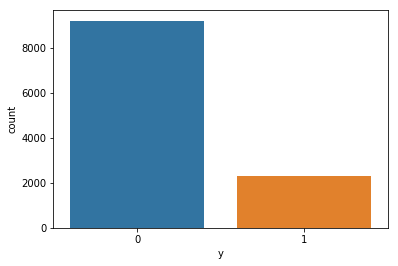

In [5]:
cols = dataset.columns
tgt = dataset.y
tgt[tgt>1]=0
ax = sn.countplot(tgt,label="Count")
non_seizure, seizure = tgt.value_counts()
print('The number of trials for the non-seizure class is:', non_seizure)
print('The number of trials for the seizure class is:', seizure)

As we can see, there are 178 EEG features and 5 possible classes. The main goal of the dataset it's to be able to correctly identify epileptic seizures from EEG data, so a binary classification between classes of label 1 and the rest (2,3,4,5). In order to train our model, let's define our independent variables (X) and our dependent variable (y).

In [6]:
X = dataset.iloc[:,1:179].values
X.shape

(11500, 178)

Text(0.5,0,'Samples')

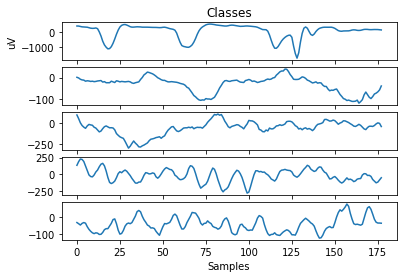

In [11]:
plt.subplot(511)
plt.plot(X[1,:])
plt.title('Classes')
plt.ylabel('uV')
plt.subplot(512)
plt.plot(X[7,:])
plt.subplot(513)
plt.plot(X[12,:])
plt.subplot(514)
plt.plot(X[0,:])
plt.subplot(515)
plt.plot(X[2,:])
plt.xlabel('Samples')

In [6]:
y = dataset.iloc[:,179].values
y

array([0, 1, 0, ..., 0, 0, 0])

To make this a binary problem, let's turn the non-seizure classes 0 while maintaining the seizure as 1.

In [7]:
y[y>1]=0
y

array([0, 1, 0, ..., 0, 0, 0])

Let's split our data between training and test. We later will employ 10-fold cross validation to ensure that our model correctly generalize to unseen data.

## Train and test splits

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

Applying scaling to our independent variables to make easier for our model to converge.

## Scaling the data

In [9]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [10]:
X_train[0,0:30]

array([-0.19147932, -0.21477354, -0.21249808, -0.25082442, -0.20864317,
       -0.19188163, -0.14740626, -0.1173909 , -0.11400036, -0.14269786,
       -0.17140752, -0.18274939, -0.15747181, -0.08557341, -0.03611843,
       -0.02916717, -0.0306056 , -0.01310075,  0.02252931,  0.03373113,
        0.04517098,  0.00946367, -0.03594922, -0.13818669, -0.19130803,
       -0.22796225, -0.23434042, -0.22147656, -0.23909917, -0.26226699])

In [11]:
y_train[0:30]

array([0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

Let's investigate how accurate the simplest model can achieve by applying a Logistic Regression to our data.

## Logistic Regression

In [ ]:
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

In [ ]:
y_pred = classifier.predict(X_test)

In [ ]:
accuracies = cross_val_score(estimator = classifier,
                             X = X_train,
                             y = y_train,
                             cv = 10,
                             n_jobs = -1)
accuracies.mean()

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred, target_names=['Non-seizure', 'Seizure']))

df_cm = pd.DataFrame(cm, range(2), range(2))
sn.heatmap(df_cm, annot=True,fmt='g',cmap ='Blues')# font size

With a simple Logistic Regression the classifier was not able to separate the classes in a linear fashion.

Let's try to apply Random Forest with boosting, more specificaly Gradient Boosting, or XGBoost.

## XGBoost

In [ ]:
clf = XGBClassifier()
clf.fit(X_train, y_train)

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
accuracies = cross_val_score(estimator = clf,
                             X = X_train,
                             y = y_train,
                             cv = 10,
                             n_jobs = -1)
accuracies.mean()

In [ ]:
accuracies.std()

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred, target_names=['Non-seizure', 'Seizure']))

df_cm = pd.DataFrame(cm, range(2), range(2))
sn.heatmap(df_cm, annot=True,fmt='g',cmap ='Blues')# font size

Using boosting techniques to the random forest classifier (XGBoost) we are able to obtain near perfect accuracies on our data! But that's not telling the whole history, let's investigate our features even further.

## Artificial Neural Networks

Let's try using a simple, shallow neural network on our problem

Train on 9200 samples, validate on 2300 samples
Epoch 1/100
9200/9200 [==============================] - 3s 348us/step - loss: 0.2635 - acc: 0.9178 - val_loss: 0.1635 - val_acc: 0.9504
Epoch 2/100
9200/9200 [==============================] - 2s 222us/step - loss: 0.1673 - acc: 0.9476 - val_loss: 0.1493 - val_acc: 0.9470
Epoch 3/100
9200/9200 [==============================] - 2s 195us/step - loss: 0.1496 - acc: 0.9489 - val_loss: 0.1325 - val_acc: 0.9474
Epoch 4/100
9200/9200 [==============================] - 2s 173us/step - loss: 0.1370 - acc: 0.9537 - val_loss: 0.1172 - val_acc: 0.9474
Epoch 5/100
9200/9200 [==============================] - 1s 152us/step - loss: 0.1188 - acc: 0.9558 - val_loss: 0.1110 - val_acc: 0.9517
Epoch 6/100
9200/9200 [==============================] - 2s 164us/step - loss: 0.1166 - acc: 0.9567 - val_loss: 0.1063 - val_acc: 0.9539
Epoch 7/100
9200/9200 [==============================] - 1s 162us/step - loss: 0.1120 - acc: 0.9592 - val_loss: 0.0931 - val_acc: 

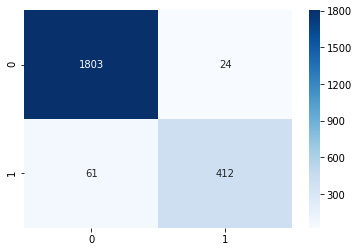

In [27]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_acc',
                                           min_delta=0,
                                           patience=10,
                                           verbose=1,
                                           mode='auto')
# Initialising the ANN
clf_ann = Sequential()

# Adding the input layer and the first hidden layer
clf_ann.add(Dense(activation="relu",
                  kernel_initializer="uniform", 
                  units=100,
                  input_dim=178))
clf_ann.add(BatchNormalization())
clf_ann.add(Dropout(0.5))
# Adding the second hidden layer
clf_ann.add(Dense(activation="relu",
                  kernel_initializer="uniform",
                  units=100))
clf_ann.add(BatchNormalization())
clf_ann.add(Dropout(0.5))
# Adding the output layer
clf_ann.add(Dense(units=1,
                  kernel_initializer="uniform",
                  activation="sigmoid"))

# Compiling the ANN
clf_ann.compile(optimizer = 'adam',
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])
# loss = 'categorical_crossentropy'
# Fitting the ANN to the Training set
clf_ann.fit(X_train, y_train,
               batch_size = 32,
               epochs = 100,
               validation_data=(X_test,y_test),
               callbacks=[early_stop])

# Part 3 - Making the predictions and evaluating the model

# Predicting the Test set results
y_pred = clf_ann.predict(X_test)
y_pred = (y_pred > 0.5)

# Making the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred, target_names=['Non-seizure', 'Seizure']))

df_cm = pd.DataFrame(cm, range(2), range(2))
sn.heatmap(df_cm, annot=True,fmt='g',cmap ='Blues')# font size

# Feature selection

In [ ]:
# find best scored 5 features
select_feature = SelectKBest(k=10).fit(X_train, y_train)

In [ ]:
x_train_2 = select_feature.transform(X_train)
x_test_2 = select_feature.transform(X_test)
#random forest classifier with n_estimators=10 (default)
clf_2 = XGBClassifier()     
clr_2 = clf_2.fit(x_train_2,y_train)

In [ ]:
y_pred = clf_2.predict(x_test_2)

accuracies = cross_val_score(estimator = clf_2,
                             X = x_train_2,
                             y = y_train,
                             cv = 10,
                             n_jobs = -1)
accuracies.mean()

In [ ]:
accuracies.std()

In [ ]:
# The "accuracy" scoring is proportional to the number of correct classifications
clf_3 = RandomForestClassifier() 
rfecv = RFECV(estimator=clf_3, step=1, cv=5,scoring='accuracy', n_jobs=-1)   #5-fold cross-validation
rfecv = rfecv.fit(X_train, y_train)

In [ ]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

## Principal Component Analysis (PCA)

In [ ]:
pca = PCA(n_components = 2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
explained_variance = pca.explained_variance_ratio_
explained_variance

In [ ]:
np.sum(explained_variance)

As we can see PCA is not a good technique for our dataset, we need at least 20 components to have ~70% of explained variance.

## Linear Discriminant Analysis (LDA)

In [ ]:
# Applying LDA
lda = LDA(n_components = 2)
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)

# Fitting Logistic Regression to the Training set
classifier = LogisticRegression()
classifier.fit(X_train_lda, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test_lda)

# Making the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred, target_names=['Non-seizure', 'Seizure']))

df_cm = pd.DataFrame(cm, range(2), range(2))
sn.heatmap(df_cm, annot=True,fmt='g',cmap ='Blues')# font size

Once again, linear predictors don't show good separation between classes

## Feature enginnering

We are using the time domain features of the EEG in our classification. The literature shows a lot of studies that proves that there are a lot of important information on the frequency domain.

Let's apply the Fourier Transform to our dataset and use the frequency domain features on our classification

In [70]:
X_new = dataset.iloc[:,1:179].values
X_new[0,0:30]

array([ 135,  190,  229,  223,  192,  125,   55,   -9,  -33,  -38,  -10,
         35,   64,  113,  152,  164,  127,   50,  -47, -121, -138, -125,
       -101,  -50,   11,   39,   24,   48,   64,   46])

In [71]:
y_fft = dataset.iloc[:,179].values
y_fft[0:30]

array([0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 0])

In [72]:
X_fft = np.fft.rfft(X_new,axis=1)
X_fft.shape

(11500, 90)

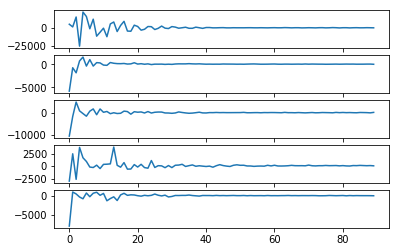

In [73]:
plt.subplot(511)
plt.plot(X_fft[1,:])
plt.subplot(512)
plt.plot(X_fft[7,:])
plt.subplot(513)
plt.plot(X_fft[12,:])
plt.subplot(514)
plt.plot(X_fft[0,:])
plt.subplot(515)
plt.plot(X_fft[2,:])

As it's evident, it was applied a lowpass filter at 40 Hz (this information is also given by the dataset owners).

So let's use only the first 40 points of our data.

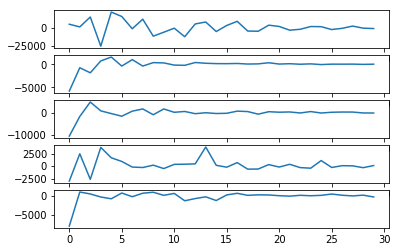

In [74]:
X_fft = X_fft[:,0:30]
plt.subplot(511)
plt.plot(X_fft[1,:])
plt.subplot(512)
plt.plot(X_fft[7,:])
plt.subplot(513)
plt.plot(X_fft[12,:])
plt.subplot(514)
plt.plot(X_fft[0,:])
plt.subplot(515)
plt.plot(X_fft[2,:])

In [75]:
X_train_fft, X_test_fft, y_train_fft, y_test_fft = train_test_split(X_fft, y, test_size = 0.2)
sc = StandardScaler()
X_train_fft = sc.fit_transform(X_train_fft)
X_test_fft = sc.transform(X_test_fft)
clf_fft = XGBClassifier()
clf_fft.fit(X_train_fft, y_train_fft)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [34]:
y_pred_fft = clf_fft.predict(X_test_fft)
accuracies = cross_val_score(estimator = clf_fft,
                             X = X_train_fft,
                             y = y_train_fft,
                             cv = 10,
                             n_jobs = -1)
accuracies.mean()

0.964565665324767

In [35]:
accuracies.std()

0.005304384138896117

             precision    recall  f1-score   support

Non-seizure       0.97      0.99      0.98      1823
    Seizure       0.96      0.88      0.92       477

avg / total       0.97      0.97      0.97      2300



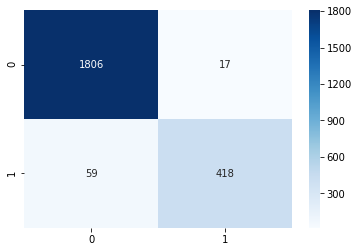

In [36]:
cm = confusion_matrix(y_test_fft, y_pred_fft)
print(classification_report(y_test_fft, y_pred_fft, target_names=['Non-seizure', 'Seizure']))

df_cm = pd.DataFrame(cm, range(2), range(2))
sn.heatmap(df_cm, annot=True,fmt='g',cmap ='Blues')# font size

### Time + frequency features

Let's see if using both features at the same time it's possible to achieve a better accuracy

In [78]:
X_fft = np.fft.rfft(X_new,axis=1)
X_fft = X_fft[:,0:30]
X_both = np.concatenate((X_new,X_fft),axis=1)
X_both.shape

(11500, 208)

In [79]:
X_train_both, X_test_both, y_train_both, y_test_both = train_test_split(X_both, y, test_size = 0.2)
sc = StandardScaler()
X_train_both = sc.fit_transform(X_train_both)
X_test_both = sc.transform(X_test_both)
clf_both = XGBClassifier()
clf_both.fit(X_train_both, y_train_both)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [52]:
y_pred_both = clf_both.predict(X_test_both)
accuracies = cross_val_score(estimator = clf_both,
                             X = X_train_both,
                             y = y_train_both,
                             cv = 10,
                             n_jobs = -1)
accuracies.mean()

0.9689130368003538

In [53]:
accuracies.std()

0.0042433267676053234

             precision    recall  f1-score   support

Non-seizure       0.97      0.99      0.98      1831
    Seizure       0.96      0.87      0.91       469

avg / total       0.97      0.97      0.97      2300



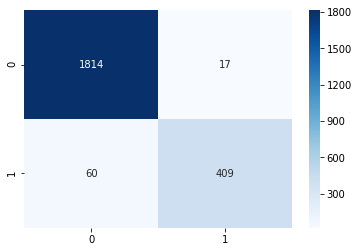

In [54]:
cm = confusion_matrix(y_test_both, y_pred_both)
print(classification_report(y_test_both, y_pred_both, target_names=['Non-seizure', 'Seizure']))

df_cm = pd.DataFrame(cm, range(2), range(2))
sn.heatmap(df_cm, annot=True,fmt='g',cmap ='Blues')# font size

Train on 9200 samples, validate on 2300 samples
Epoch 1/100
9200/9200 [==============================] - 5s 525us/step - loss: 0.2597 - acc: 0.9195 - val_loss: 0.1343 - val_acc: 0.9596
Epoch 2/100
9200/9200 [==============================] - 2s 222us/step - loss: 0.1769 - acc: 0.9425 - val_loss: 0.1166 - val_acc: 0.9565
Epoch 3/100
9200/9200 [==============================] - 2s 206us/step - loss: 0.1523 - acc: 0.9482 - val_loss: 0.1075 - val_acc: 0.9561
Epoch 4/100
9200/9200 [==============================] - 2s 217us/step - loss: 0.1309 - acc: 0.9536 - val_loss: 0.0953 - val_acc: 0.9622
Epoch 5/100
9200/9200 [==============================] - 2s 221us/step - loss: 0.1272 - acc: 0.9537 - val_loss: 0.0870 - val_acc: 0.9652
Epoch 6/100
9200/9200 [==============================] - 2s 255us/step - loss: 0.1112 - acc: 0.9578 - val_loss: 0.0864 - val_acc: 0.9661
Epoch 7/100
9200/9200 [==============================] - 2s 231us/step - loss: 0.1152 - acc: 0.9572 - val_loss: 0.0758 - val_acc: 

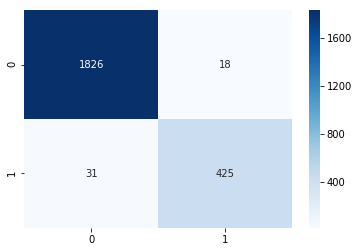

In [80]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_acc',
                                           min_delta=0,
                                           patience=10,
                                           verbose=1,
                                           mode='auto')
# Initialising the ANN
clf_ann2 = Sequential()

# Adding the input layer and the first hidden layer
clf_ann2.add(Dense(activation="relu",
                  kernel_initializer="uniform", 
                  units=100,
                  input_dim=208))
clf_ann2.add(BatchNormalization())
clf_ann2.add(Dropout(0.5))
# Adding the second hidden layer
clf_ann2.add(Dense(activation="relu",
                  kernel_initializer="uniform",
                  units=100))
clf_ann2.add(BatchNormalization())
clf_ann2.add(Dropout(0.5))

# Adding the output layer
clf_ann2.add(Dense(units=1,
                  kernel_initializer="uniform",
                  activation="sigmoid"))

# Compiling the ANN
clf_ann2.compile(optimizer = 'adam',
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])
# loss = 'categorical_crossentropy'
# Fitting the ANN to the Training set
clf_ann2.fit(X_train_both, 
            y_train_both,
            batch_size = 32,
            epochs = 100,
            validation_data=(X_test_both,y_test_both),
            callbacks=[early_stop])

# Part 3 - Making the predictions and evaluating the model

# Predicting the Test set results
y_pred_both = clf_ann2.predict(X_test_both)
y_pred_both = (y_pred_both > 0.5)

# Making the Confusion Matrix
cm = confusion_matrix(y_test_both, y_pred_both)
print(classification_report(y_test_both, y_pred_both, target_names=['Non-seizure', 'Seizure']))

df_cm = pd.DataFrame(cm, range(2), range(2))
sn.heatmap(df_cm, annot=True,fmt='g',cmap ='Blues')# font size

## Oversampling our seizure class

As we saw in the beginning of this notebook, our classes are imbalanced.

- 2300 seizure trials (20%)
- 9200 non-seizure trials (80%)

This could lead to a common problem in classification: the accuracy paradox.
If our classifier chooses to go all in on the non-seizure class, it still achieves 80% accuracy!

We dealt with this problem nicely by investigating other metrics of our classifier and our model seems to generalize well.

### SMOTE

Other technique used to deal with imbalanced classes is oversampling. Let's investigate on our data.

In [4]:
from imblearn.over_sampling import SMOTE
X_s = dataset.iloc[:,1:179].values
y_s = dataset.iloc[:,179].values

In [6]:
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_s, y_s,test_size = 0.2)
sm = SMOTE(ratio = 1.0)
X_train_res, y_train_res = sm.fit_sample(X_train_s, y_train_s)

(14664, 178)

Train on 14664 samples, validate on 2300 samples
Epoch 1/100
14664/14664 [==============================] - 4s 273us/step - loss: 0.2322 - acc: 0.9120 - val_loss: 0.1085 - val_acc: 0.9652
Epoch 2/100
14664/14664 [==============================] - 3s 218us/step - loss: 0.1915 - acc: 0.9277 - val_loss: 0.1058 - val_acc: 0.9626
Epoch 3/100
14664/14664 [==============================] - 3s 222us/step - loss: 0.1824 - acc: 0.9321 - val_loss: 0.0956 - val_acc: 0.9709
Epoch 4/100
14664/14664 [==============================] - 3s 227us/step - loss: 0.1799 - acc: 0.9331 - val_loss: 0.1159 - val_acc: 0.9587
Epoch 5/100
14664/14664 [==============================] - 3s 222us/step - loss: 0.1861 - acc: 0.9294 - val_loss: 0.0991 - val_acc: 0.9674
Epoch 6/100
14664/14664 [==============================] - 3s 224us/step - loss: 0.1775 - acc: 0.9334 - val_loss: 0.1076 - val_acc: 0.9643
Epoch 7/100
14664/14664 [==============================] - 3s 222us/step - loss: 0.1654 - acc: 0.9394 - val_loss: 0.0

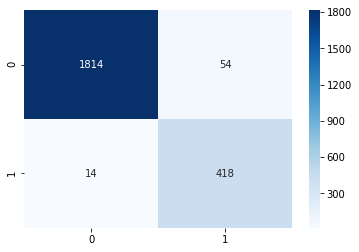

In [9]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_acc',
                                           min_delta=0,
                                           patience=10,
                                           verbose=1,
                                           mode='auto')
# Initialising the ANN
clf_ann = Sequential()

# Adding the input layer and the first hidden layer
clf_ann.add(Dense(activation="relu",
                  kernel_initializer="uniform", 
                  units=100,
                  input_dim=178))
clf_ann.add(BatchNormalization())
clf_ann.add(Dropout(0.5))
# Adding the second hidden layer
clf_ann.add(Dense(activation="relu",
                  kernel_initializer="uniform",
                  units=100))
clf_ann.add(BatchNormalization())
clf_ann.add(Dropout(0.5))
# Adding the second hidden layer
clf_ann.add(Dense(activation="relu",
                  kernel_initializer="uniform",
                  units=100))
clf_ann.add(BatchNormalization())
clf_ann.add(Dropout(0.5))
# Adding the output layer
clf_ann.add(Dense(units=1,
                  kernel_initializer="uniform",
                  activation="sigmoid"))

# Compiling the ANN
clf_ann.compile(optimizer = 'adam',
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])
# loss = 'categorical_crossentropy'
# Fitting the ANN to the Training set
clf_ann.fit(X_train_res, y_train_res,
               batch_size = 32,
               epochs = 100,
               validation_data=(X_test_s,y_test_s),
               callbacks=[early_stop])

# Part 3 - Making the predictions and evaluating the model

# Predicting the Test set results
y_pred_s = clf_ann.predict(X_test_s)
y_pred_s = (y_pred_s > 0.5)

# Making the Confusion Matrix
cm = confusion_matrix(y_test_s, y_pred_s)
print(classification_report(y_test_s, y_pred_s, target_names=['Non-seizure', 'Seizure']))

df_cm = pd.DataFrame(cm, range(2), range(2))
sn.heatmap(df_cm, annot=True,fmt='g',cmap ='Blues')# font size

# Predicting 5 classes

Now, let's transform the problem in a 5 class classification, this time we wont transform our targets

In [81]:
dataset = pd.read_csv('epileptic_seizure_recognition.csv')
dataset.head()

,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,5


In [82]:
X = dataset.iloc[:,1:179].values
X[0,0:30]

array([ 135,  190,  229,  223,  192,  125,   55,   -9,  -33,  -38,  -10,
         35,   64,  113,  152,  164,  127,   50,  -47, -121, -138, -125,
       -101,  -50,   11,   39,   24,   48,   64,   46])

In [83]:
y = dataset.iloc[:,179].values
y[0:30]

array([4, 1, 5, 5, 5, 5, 4, 2, 1, 4, 5, 1, 3, 4, 2, 3, 2, 3, 4, 2, 1, 2,
       1, 1, 1, 3, 5, 1, 2, 2])

2300 2300 2300 2300 2300


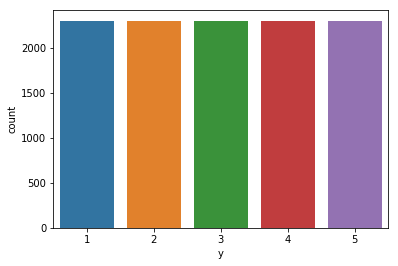

In [84]:
tgt = dataset.y
ax = sn.countplot(tgt,label="Count")
a,b,c,d,e = tgt.value_counts()
print(a,b,c,d,e)

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [86]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
classifier = XGBClassifier()
classifier.fit(X_train, y_train)

In [ ]:
y_pred = classifier.predict(X_test)

accuracies = cross_val_score(estimator = classifier,
                             X = X_train,
                             y = y_train,
                             cv = 10,
                             n_jobs = -1)
accuracies.mean()

In [ ]:
accuracies.std()

In [ ]:
cm = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred, target_names=['Seizure',
                                                          'Tumor Area',
                                                          'Healthy Area',
                                                          'Eyes closed',
                                                          'Eyes opened']))


df_cm = pd.DataFrame(cm, range(5), range(5))
sn.heatmap(df_cm, annot=True,fmt='g',cmap ='Blues')# font size

In [109]:
X = dataset.iloc[:,1:179].values
y = dataset.iloc[:,179].values
y = y-1

In [110]:
import scipy.sparse
indptr = range(len(y)+1)
data = np.ones(len(y))
y_ann = scipy.sparse.csr_matrix((data, y, indptr))

<11500x5 sparse matrix of type '<class 'numpy.float64'>'
	with 11500 stored elements in Compressed Sparse Row format>

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, y_ann, test_size = 0.2)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

Train on 9200 samples, validate on 2300 samples
Epoch 1/100
9200/9200 [==============================] - 6s 651us/step - loss: 1.2506 - acc: 0.4320 - val_loss: 1.0878 - val_acc: 0.5591
Epoch 2/100
9200/9200 [==============================] - 2s 256us/step - loss: 1.1119 - acc: 0.5003 - val_loss: 1.0065 - val_acc: 0.5861
Epoch 3/100
9200/9200 [==============================] - 2s 267us/step - loss: 1.0497 - acc: 0.5270 - val_loss: 0.9494 - val_acc: 0.6087
Epoch 4/100
9200/9200 [==============================] - 2s 269us/step - loss: 1.0104 - acc: 0.5400 - val_loss: 0.9431 - val_acc: 0.5835
Epoch 5/100
9200/9200 [==============================] - 2s 272us/step - loss: 0.9941 - acc: 0.5496 - val_loss: 0.9064 - val_acc: 0.6217
Epoch 6/100
9200/9200 [==============================] - 3s 276us/step - loss: 0.9733 - acc: 0.5566 - val_loss: 0.9376 - val_acc: 0.5761
Epoch 7/100
9200/9200 [==============================] - 2s 272us/step - loss: 0.9631 - acc: 0.5649 - val_loss: 0.9010 - val_acc: 

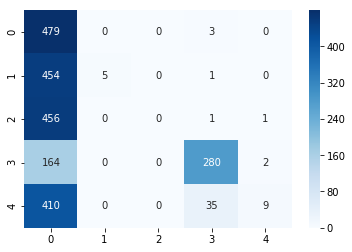

In [113]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_acc',
                                           min_delta=0,
                                           patience=10,
                                           verbose=1,
                                           mode='auto')
# Initialising the ANN
clf_ann3 = Sequential()

# Adding the input layer and the first hidden layer
clf_ann3.add(Dense(activation="relu",
                  kernel_initializer="uniform", 
                  units=100,
                  input_dim=178))
clf_ann3.add(BatchNormalization())
clf_ann3.add(Dropout(0.5))
# Adding the second hidden layer
clf_ann3.add(Dense(activation="relu",
                  kernel_initializer="uniform",
                  units=100))
clf_ann3.add(BatchNormalization())
clf_ann3.add(Dropout(0.5))

# Adding the output layer
clf_ann3.add(Dense(units=5,
                  kernel_initializer="uniform",
                  activation="softmax"))

# Compiling the ANN
clf_ann3.compile(optimizer = 'adam',
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])
# loss = 'categorical_crossentropy'
# Fitting the ANN to the Training set
clf_ann3.fit(X_train, 
            y_train,
            batch_size = 32,
            epochs = 100,
            validation_data=(X_test,y_test),
            callbacks=[early_stop])

# Part 3 - Making the predictions and evaluating the model

# Predicting the Test set results
y_pred = clf_ann3.predict(X_test)
y_pred = (y_pred > 0.5)

# Making the Confusion Matrix
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print(classification_report(y_test, y_pred, target_names=['Seizure',
                                                          'Tumor Area',
                                                          'Healthy Area',
                                                          'Eyes closed',
                                                          'Eyes opened']))


df_cm = pd.DataFrame(cm, range(5), range(5))
sn.heatmap(df_cm, annot=True,fmt='g',cmap ='Blues')# font size